# Tanzania Water Wells Classificaton Data Exploration and Cleaning

## Problem Overview

* ### Project Objectives

## Data Understanding

In [46]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

sns.set_style('darkgrid')

In [47]:
# import and view data
train_set = pd.read_csv('Data/train_set.csv')
train_set_labels = pd.read_csv('Data/train_set_labels.csv')
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [48]:
#labels
train_set_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [49]:
print('Labels:', train_set_labels['status_group'].unique())

Labels: ['functional' 'non functional' 'functional needs repair']


> * The problem is *ternary*. Need to modify it to approach it as a *binary* classification problem.

In [50]:
#mergepredictors and labels for eda
labelled_train_set = pd.merge(train_set, train_set_labels, on='id')
labelled_train_set.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


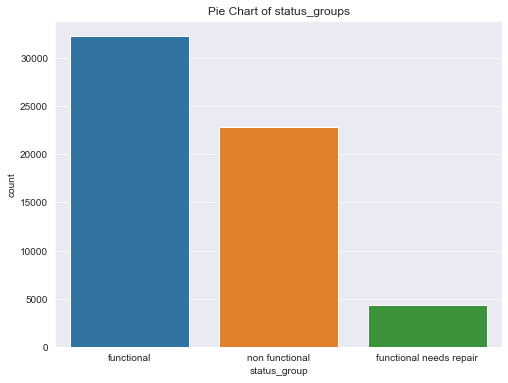

In [51]:
#plot pie chart of status_groups
plt.figure(figsize=(8,6))
sns.countplot(x='status_group', data=labelled_train_set)
plt.title('Pie Chart of status_groups')
plt.show()

> * It would be best to convert `functional needs repair` and `non functional` into a single column to make the problem binary

In [53]:
#change subgroup names and convert to binary
labelled_train_set['status_group'] = labelled_train_set['status_group'].replace(['functional needs repair', 'non functional'], 'needs_repair')
labelled_train_set['status_group'].value_counts()

functional      32259
needs_repair    27141
Name: status_group, dtype: int64

In [54]:
labelled_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [65]:
#shape
categorical = labelled_train_set.select_dtypes(include='object').columns
numerical = labelled_train_set.select_dtypes(include='number').columns
print('shape:', labelled_train_set.shape)
print('categorical columns:', categorical.values)
print('numerical columns:', numerical.values)

shape: (59400, 41)
categorical columns: ['date_recorded' 'funder' 'installer' 'wpt_name' 'basin' 'subvillage'
 'region' 'lga' 'ward' 'public_meeting' 'recorded_by' 'scheme_management'
 'scheme_name' 'permit' 'extraction_type' 'extraction_type_group'
 'extraction_type_class' 'management' 'management_group' 'payment'
 'payment_type' 'water_quality' 'quality_group' 'quantity'
 'quantity_group' 'source' 'source_type' 'source_class' 'waterpoint_type'
 'waterpoint_type_group' 'status_group']
numerical columns: ['id' 'amount_tsh' 'gps_height' 'longitude' 'latitude' 'num_private'
 'region_code' 'district_code' 'population' 'construction_year']


## Cleaning

### Missing values

In [61]:
#loop over columns and extract missing value percentages
for col in labelled_train_set.columns:
    print(f'{col}missing: {labelled_train_set[col].isna().sum()/len(labelled_train_set[col])}%')

idmissing: 0.0%
amount_tshmissing: 0.0%
date_recordedmissing: 0.0%
fundermissing: 0.0611952861952862%
gps_heightmissing: 0.0%
installermissing: 0.061531986531986535%
longitudemissing: 0.0%
latitudemissing: 0.0%
wpt_namemissing: 0.0%
num_privatemissing: 0.0%
basinmissing: 0.0%
subvillagemissing: 0.0062457912457912455%
regionmissing: 0.0%
region_codemissing: 0.0%
district_codemissing: 0.0%
lgamissing: 0.0%
wardmissing: 0.0%
populationmissing: 0.0%
public_meetingmissing: 0.05612794612794613%
recorded_bymissing: 0.0%
scheme_managementmissing: 0.06526936026936027%
scheme_namemissing: 0.4741750841750842%
permitmissing: 0.05144781144781145%
construction_yearmissing: 0.0%
extraction_typemissing: 0.0%
extraction_type_groupmissing: 0.0%
extraction_type_classmissing: 0.0%
managementmissing: 0.0%
management_groupmissing: 0.0%
paymentmissing: 0.0%
payment_typemissing: 0.0%
water_qualitymissing: 0.0%
quality_groupmissing: 0.0%
quantitymissing: 0.0%
quantity_groupmissing: 0.0%
sourcemissing: 0.0%
sou